## Cellpose trained to learn scale

There is much confusion around the cellpose 'diameter' parameter.   As far as I can tell it is simply used to rescale the image with the ratio

```
mean_of_training_diameters/diameter
```

If the training data has a mixture of small and large objects, cellpose can learn these.   This can be shown with a simple simulation.  

In [1]:
import raster_geometry as rg
import numpy as np
from tnia.simulation.phantoms import add_small_to_large_2d
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d
import math

## Make a super simple fake dataset

It only has 2 objects, object 1 with diameter of 6, object 2 with diameter of 140

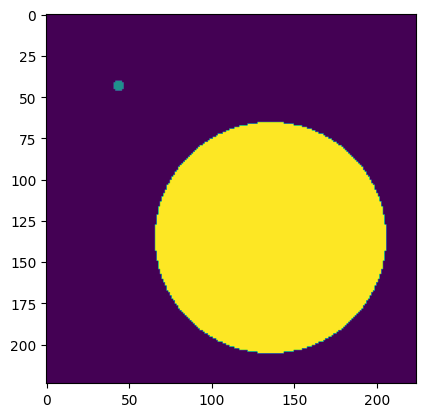

In [2]:
width, height = 224, 224

image = np.zeros([height, width], dtype=np.float32)
truth = np.zeros([height, width], dtype=np.float32)

x, y = 44, 44
r = 3 
size = [math.ceil(r*2), math.ceil(r*2)]
temp=rg.circle(size, r)
add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
add_small_to_large_2d(truth, temp, x, y, mode='replace_non_zero')

x, y = 136, 136
r = 70
size = [math.ceil(r*2), math.ceil(r*2)]
temp=rg.circle(size, r)
add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
add_small_to_large_2d(truth, 2*temp, x, y, mode='replace_non_zero')

plt.imshow(truth)

## Load Cyto2

We also print the mean diameter of cyto2 (if log is on this will print by default too)

In [3]:
from cellpose import models, io
model_cyto2 = models.CellposeModel(gpu=True, model_type="cyto2")
print('cyto2 diameter mean', model_cyto2.diam_labels)

cyto2 diameter mean 30.0


## Process with different diameters and cyto2

We try 6, default (which was 30), and 140 (use the same diameters as our 2 objects)

It looks like d=6 finds the small object, d=140 finds the big one, and default finds only the small one. 

Note that the samll object is not the same size between d=6 and default. 

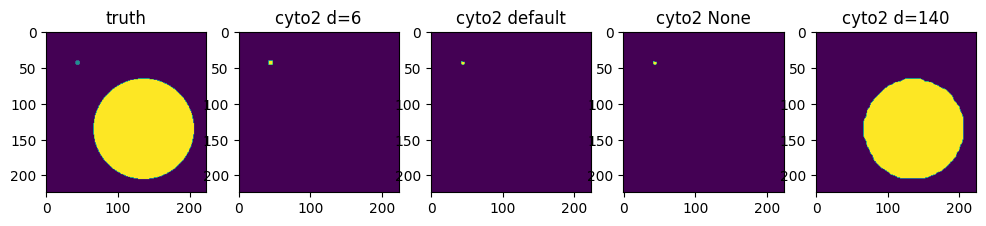

In [4]:
labels_d6 = model_cyto2.eval(truth, channels=[0, 0],diameter=6,flow_threshold=0.8, cellprob_threshold=-0.8)[0]
labels_default = model_cyto2.eval(truth, channels=[0, 0], flow_threshold=0.8, cellprob_threshold=-0.8)[0]
labels_none = model_cyto2.eval(truth, channels=[0, 0], diameter = None, flow_threshold=0.8, cellprob_threshold=-0.8)[0]
labels_d140 = model_cyto2.eval(truth, channels=[0, 0],diameter=140,flow_threshold=0.8, cellprob_threshold=-0.8)[0]
fig = imshow_multi2d([truth, labels_d6, labels_default, labels_none, labels_d140], ['truth', 'cyto2 d=6', 'cyto2 default', 'cyto2 None', 'cyto2 d=140'],1 ,5, width = 12, height = 6)


## Repeat the objects to make a fake training set

Just repeat a few times to make a trivial training set.  No need to even add blur or noise, we just want to see if a custom model can learn different scales. 

In [4]:
X = [image.copy().astype('float32')[..., np.newaxis] for i in range(10)]
Y = [truth.copy().astype('uint16') for i in range(10)]

## Make a custom model

In [5]:
import os

model_path = r'./'
model_name = 'custom'
logger = io.logger_setup()
model_custom = models.CellposeModel(gpu=True, model_type=None, pretrained_model=os.path.join(model_path,'models',model_name))

creating new log file
2024-06-13 09:05:06,995 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-06-13 09:05:06,996 [INFO] 
cellpose version: 	3.0.9 
platform:       	win32 
python version: 	3.10.14 
torch version:  	2.2.2+cu118
2024-06-13 09:05:06,999 [INFO] ** TORCH CUDA version installed and working. **
2024-06-13 09:05:07,000 [INFO] >>>> using GPU
2024-06-13 09:05:07,098 [INFO] >>>> loading model ./models\custom
2024-06-13 09:05:07,252 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-06-13 09:05:07,253 [INFO] >>>> model diam_labels =  73.160 (mean diameter of training ROIs)


In [7]:
model_path

'./'

## Train our custom model

Note if the log is on it will report the average diameter or the training objects (which should be (6+140)/2=73)

In [9]:
from cellpose import train

test=train.train_seg(model_custom.net, X, Y, 
    channels=[0,1], 
    save_path=model_path, 
    n_epochs=20,
    nimg_per_epoch=10,
    min_train_masks=1,
    model_name=model_name)

2024-06-13 09:11:49,657 [INFO] computing flows for labels


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

2024-06-13 09:11:52,230 [INFO] >>> computing diameters



100%|██████████| 10/10 [00:00<00:00, 1103.07it/s]

2024-06-13 09:11:52,246 [INFO] >>> using channels [0, 1]
2024-06-13 09:11:52,247 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': False, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
2024-06-13 09:11:52,280 [INFO] >>> n_epochs=20, n_train=10, n_test=None
2024-06-13 09:11:52,281 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001



c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-06-13 09:11:53,559 [INFO] >>> saving model to models\custom
2024-06-13 09:11:54,797 [INFO] 0, train_loss=0.0050, test_loss=0.0000, LR=0.0000, time 1.24s
2024-06-13 09:11:55,482 [INFO] 5, train_loss=0.0125, test_loss=0.0000, LR=0.0028, time 1.92s
2024-06-13 09:11:56,148 [INFO] 10, train_loss=0.0108, test_loss=0.0000, LR=0.0050, time 2.59s


In [14]:
labels_custom = model_custom.eval(X[0][0,:,:], channels=[0, 1])[0]

## Show all the cyto labels and label custom

Note, cyto can only find objects of different sizes by tuning the ```diameter``` param.  Custom can find very different object sizes by default. 

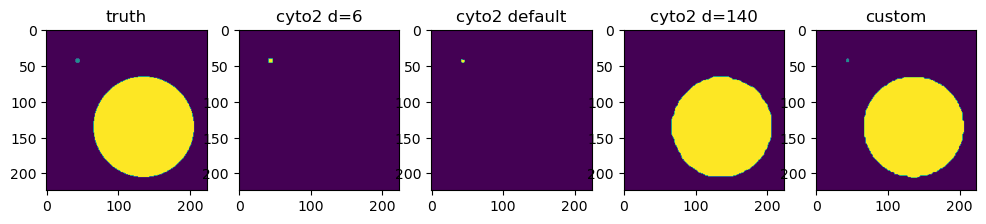

In [35]:
fig = imshow_multi2d([truth, labels_d6, labels_default, labels_d140, labels_custom], ['truth', 'cyto2 d=6', 'cyto2 default', 'cyto2 d=140', 'custom'],1 ,5, width = 12, height = 6)

In [21]:
print(model_custom.diam_labels)
print(model_cyto2.diam_labels)

73.16014584338242
30.0
